# Francis Regalado

# Final project

# Set up
Important and configure models

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False


import numpy as np
import PIL.Image
import time
import functools

import IPython.display as display
import time

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import utils
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback

from numpy import array
from tensorflow.keras import datasets, layers, models 
keras = tf.keras
import sys

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
#Shows my directory so i know what files are present.
import os
print(os.getcwd())
img_path = os.path.join(os.getcwd())
print(img_path)
print(os.listdir(img_path))

/Users/francisregalado/Desktop/Machine Learning/Final
/Users/francisregalado/Desktop/Machine Learning/Final
['IMG_3290.JPG', 'New_Koy.png', 'Axolotl3.jpg', '.DS_Store', 'Final_final.ipynb', 'Axolotl1.HEIC', 'New_axolotl.png', 'New_axolotl_1.png', 'Untitled.ipynb', 'Axolotl6.HEIC', 'Blue.png', 'Koy.png', 'Axolotl_starry.png', 'Axolotl7.HEIC', 'Style Transfer Final.ipynb', 'Axolotl.png', 'Wave.png', 'Final_Project.ipynb', 'Axolotl5.HEIC', '.ipynb_checkpoints', 'Starry_night.png', 'Axolotl2.HEIC', 'Final Project.ipynb', 'style_transfer.ipynb', 'Final_project_starrynight.ipynb']


In [4]:
#importing the images
#the base picture
content_path = tf.keras.utils.get_file('Axolotl.png', 'file:///Users/francisregalado/Desktop/Machine%20Learning/Final/Axolotl.png')

#The picture to be used for the pattern
style_path = tf.keras.utils.get_file('Wave.png','file:///Users/francisregalado/Desktop/Machine%20Learning/Final/Wave.png')

In this section we create two paths, the content path which is the base picture to be used. The Style path is going to be the picture which art style we want to mimic. We upload the picture directory from the laptop directly into the browser and load into the code.

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [5]:
#Makes the maximum amount pixels the image may have at 512 pixels
def load_img(path_to_img):
    max_dim = 512 #max pixel size
    img = tf.io.read_file(path_to_img) #read image
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #converts to float32

    #fixes the shape/size
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

#scales the pixels
    new_shape = tf.cast(shape * scale, tf.int32)

#returns the new size of the image
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In this block we create a function to load the images and change their sizes. We set the max pixel size to 512. By converting both images to float32, it allows for easy manipulation. Once it has been scaled, the new image sizes are returned.

Creates function to visualize the images

In [6]:
#compresses the image and puts it in a graph
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

        plt.imshow(image)
        if title:
            plt.title(title)

In this block we create a function to plot both images into graphs for easily comparison, also demonstrating pixel sizes.

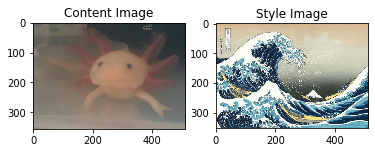

In [7]:
#loads and displays both images
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image') #plots the main image

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')# plots image im going to use as the style

# Define content and style representations
I'm going to modify the layers of the VGG19.

In this block we loaded the VGG19 from keras, which is 19 layers deep. It is applied to the content image * 255 for the pixel size, and resized. Once it is applied to the imagenet, its prediction array printed, showing it's shape

Next we shall load a VGG19 without the classification head, and list the layer names

In [8]:
#Load a VGG19 and test run it on our image to ensure it's used correctly:
#Loads VGG19
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

Here we shall print out a summary to view all the layers within the VGG19

In [9]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Here I will add my own layers to the model, as well as freeze the last 4 layers, allowing me to add the new changes to the model

In [10]:
basemodel = vgg
vgg = keras.Sequential(basemodel.layers[:-5])
vgg.add(keras.layers.Conv2D(512, (7, 7), activation= 'relu', name = 'New_block'))
vgg.add(keras.layers.Flatten())
vgg.add(keras.layers.Dense(8192, activation='relu', name = 'New_fc1'))
vgg.add(keras.layers.Dense(2, activation='softmax', name = 'New_fc2'))
vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

Now to view all the layers in the new VGG models

In [11]:
print()
for layer in vgg.layers:
    print(layer.name)


block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
New_block
flatten
New_fc1
New_fc2


In [12]:
#block5_conv2 gives my final picture a better merge design than using block1_conv1 or block4_conv2
content_layers = ['block5_conv2'] #Main layer to be applied to the content image

#all layers to be applied to the style image
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

The most important section for Neural style transfer. Here is where we choose which layers to work with specifically and the order they will be applied. I have mixed and matched layers and found the best result for the final image in my opnion comes from using this combination. A base layer is chosen for the content_layer. Next, we shall choose 5 layers to apply into the style_layer. The order of the layers has to increase preeceeding the layers number before it. I use conv2 because I personally enjoy how it blends the content with the style layers.

In [13]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [14]:
#Creates the model
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
#print out the shape of the layers, the min, max and mean values of each layer
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 352, 512, 64)
  min:  0.0
  max:  868.7998
  mean:  34.292816

block2_conv1
  shape:  (1, 176, 256, 128)
  min:  0.0
  max:  4341.767
  mean:  214.80331

block3_conv1
  shape:  (1, 88, 128, 256)
  min:  0.0
  max:  10881.143
  mean:  201.4773

block4_conv1
  shape:  (1, 44, 64, 512)
  min:  0.0
  max:  21606.213
  mean:  760.41235

block5_conv1
  shape:  (1, 22, 32, 512)
  min:  0.0
  max:  2872.1013
  mean:  56.705357



Here we are extracting the information in the style layers, by *255 since it is the size of the image, and printing out the shape, min, max, and mean values of each of the five layers I had assigned to be stored in the style layer.

Formula used to calculate the style

In [15]:
#Calculates the style
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

We define the function called gram_matrix. In the content of the image, it is represented by the values of common features located on the map. By calculated the Gram Matrix, thich includes the values of common features by taking the output product over all the locations.

This model returns the style and content tensors.

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0 #converts to 0, or 1
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

This class builds the model which is returned to the style and content tensor. The style layers and content layers are merged in the vgg layers and passed to self vgg which is not trainable. A function called call, converts the inputs to 0 or 1's whcih allows to be used for individual pixels. Now, one can apply the gram matrix to the style outputs, the content layers, the style layers and all is returned.

Returns the gram matrix style of the style_layers and content of the content_layers

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0032742212
    max:  5360.1943
    mean:  77.445

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  8719.239
    mean:  1397.901

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.085364
    max:  44101.574
    mean:  962.3366

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  448764.94
    mean:  22333.81

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  8010.399
    mean:  135.28296

Contents:
   block5_conv2
    shape:  (1, 22, 31, 512)
    min:  0.0
    max:  491.28864
    mean:  4.1508036


Here the new values with the gram matrix are printed out, showing the shape, min, max and mean of each of the layers.

In [18]:
#style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [19]:
#optimizes the content image. The tf variable must be the same shape as the content image
image = tf.Variable(content_image)

The tf.Variable contains the image which shall be held whcih has to be the same shape as the content image. It is inizialized with the help of the content image.

In [20]:
#keeps the value of the pixels between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

This function keeps pixels in the image which is a float between the values of 0 and 1.

In [21]:
#Creating the optomizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [22]:
#weighted combination of the two losses to get the total loss. Style is always less than the content since the Content image has to be more dominant.
style_weight=1e-2
content_weight=1e4

The weighted combination, the style is always less than the content since the Content image has to be more dominant. If not, the effect will not properly take place.

In [23]:
#Creates function to calculate the style content loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [24]:
#Function to update the new image after loss is applied
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [25]:
#define function that puts the x and y into arrays
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [26]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

Here,the frequency components have increased. The edges in the content image stand out more which is what allows for those pixels to be predoment when the merge occurs.

In [27]:
total_variation_loss(image).numpy()

4150.3086

This is how tensorflow gives the standard implementation, which does the same as the as the block above.

In [28]:
tf.image.total_variation(image).numpy()

array([4150.3086], dtype=float32)

In [29]:
#weight for the total variation loss
total_variation_weight=30

Here is applied the weight for the amount of variation loss you want to add, anything more than 30 mixes the styles too greatly and does not give too great of quality. A variation weight of 30 lets both the content image be seen accurately with the art style of the style image. It gave me the mix I was trying to achieve.

In [30]:
#applies total_variation weight to the train step function
#incorporate the style content loss and total variation weight into the loss and apply to the output of the image
#applies this to the pixels (0 and 1's)
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

This incorporates the style content loss and total variation weight into the loss and applies it to the output of the image. This is where the application of the pixels occures. This is the reason why the values were converted and kept between 0 and 1's.

In [31]:
#gives the optimization variable into the image
image = tf.Variable(content_image)

Now the variable from the content image is applied. It is given to image.

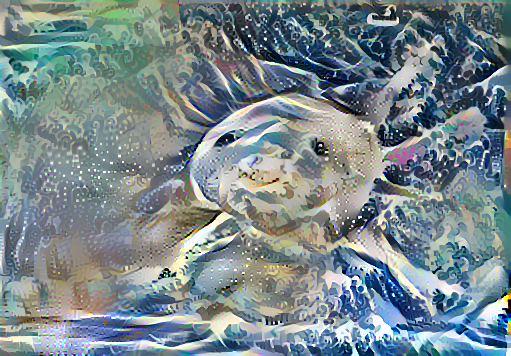

Train step: 1000
Total time: 4285.4


In [32]:
#Starts the model
#runs 10 epochs, given 100 steps per epoch
#Every time it completes a step, prints . . . until the epoch is complete, then clears them and begins new . . .
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


Here all the optimizations are ran. It will print the total time taken to achieve the epochs assigned. I have assigned 10 epochs. It begins at 0, and there are 100 steps per epoch, every time one step is completed, it prints out a "." . Once all 100 "." are done and the steps are done, the epoch is done and it begins again, clearing the "." previously printed, repeating the process. The way i set up the for loop, it's going to display all of the changes which occur in the image and print it out, as well as label which step is the epoch currently on. Once all 10 epochs are finished, it shall display the new finilized image with all applied layers, as well as the amount of steps completed, and the total time. In my case, it completed 1,000 steps in a time of 4285.4. By applying my new layers into the VGG network, I was able to actually make my model complete the epoch 10 epochs faster. Before i applied the new layers and froze the layers, the Total time to complete 1000 steps was 5104.7, now I cut it down by at almost 900. The new layers even made a form of a smile appear in the face of the axolotl, which was not seen before the modificaitons were applied.

In [33]:
#Prints the final image and saves it to your machine
file_name = 'New_axolotl2.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

This is to save and download the new image. Using tensorflow to save the assigned file name, it saves to the directory.